# Mwansa Mathews
# Stock Price Prediction with Long Short Term Memory (LSTM)
# African Institute for Mathematical Sciences (AIMS), South Africa.

**Machine learning is considered as a subfield of Artificial Intelligence (AI), a field that makes use of algorithms which are supervised by humans to transform the unstructured and structured patterns of data into knowledge. This has helped to solve the enormous problems of the world and bring a huge change in the area of machine learning.**

**This code use a non-linear model Long Short Term Memory (LSTM) which is a type of Recurrent Neural Network (RNN) to predict the daily stock prices for the Netherlands stock Exchange (AMSTEOE).**

** More interesting explanation about LSTM  model can be found on Colah's blog,
http://colah.github.io/posts/2015-08-Understanding-LSTMs/** 

**For now we draw our attention to implementing the LSTM model in python using a computational frame work, Tensorflow.**

## Import Libraries

In [1]:
import tensorflow as tf

In [2]:
import keras

Using TensorFlow backend.


In [3]:
import pandas as pd
import numpy as np
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
from keras.layers import Embedding
import time
from sklearn.metrics import mean_squared_error, mean_absolute_error
from matplotlib import pyplot
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from keras import optimizers
from numpy.random import seed
seed(12)

### Reading data into notebook
** In this code, we will use historical data for different stock indices put together. The source of the data is unknown.** 

** We use the code below to read the data:**

In [4]:
Stock_Prices=pd.read_csv('st_indices.csv',index_col=0)
Stock_Prices.head() 


,AMSTEOE,DAXINDX,FRCAC40,FTSE100,HNGKNGI,PDOWA,GALLS,COMP
0,261.36,1411.28,1482.89,2371.0,3225.97,23755.89,387.17,307.52
1,262.02,1419.76,1490.42,2382.0,3207.21,24102.98,391.44,308.37
2,263.32,1431.03,1490.42,2386.6,3216.11,24118.01,393.99,307.63
3,264.98,1440.47,1490.42,2403.0,3253.42,23931.52,390.23,310.68
4,264.50,1462.16,1490.42,2419.2,3262.30,23969.76,395.71,310.42


### We can see that the data contains 2734 daily observations and we are interested in forecating the first column

In [7]:
Stock_Prices.shape

(2734, 8)


## Normalizing the Data

** In order to feed the data in the LSTM model, we must re-scale it into variables that share the same time scales, the data is normalized by the code below:**

In [8]:
p =Stock_Prices.AMSTEOE.values.reshape(-1, 1)

scaler_1 = MinMaxScaler(feature_range=(0, 1))
Stock_vector_1 = scaler_1.fit_transform(p)

In [9]:
Stock_Prices_2=Stock_Prices.values[:, 1:]
Stock_Prices_2.shape, Stock_Prices_2[0]

((2734, 7), array([ 1411.28,  1482.89,  2371.  ,  3225.97, 23755.89,   387.17,
          307.52]))

In [10]:
scaler_2 = MinMaxScaler(feature_range=(0, 1))
Stock_vector_2 = scaler_2.fit_transform(Stock_Prices_2)

In [11]:
Stock_vector_2.shape

(2734, 7)

In [12]:
Stock_vector_2[0]

array([0.13686836, 0.26773597, 0.2139898 , 0.09006633, 0.38390244,
       0.3786569 , 0.11001882])

In [13]:
scaler_ = MinMaxScaler(feature_range=(0, 1))
Stock_vector = scaler_.fit_transform(Stock_Prices.values)

In [14]:
Stock_vector=np.append( Stock_vector_1,Stock_vector_2, axis=1)


## Reshape Data for LSTM Input

** In order to provide the scaled data to every LSTM layer, we must convert it into three-dimensional**
- Input shape
     - **Samples.** Represents the sample size, in this case we have 2734 observations.
	 - **Time Step.** One time step is one point of look back in the sample.
	 - **Feature.** The variable observed to give direction for prediction at a time step.


In [17]:
def rnn_data_setup(data, lookback, delay, min_index, max_index):
    '''
    data:     Shape (n_samples,n_features). First column is the time series, other columns are the features
    lookback: Number of time steps in the RNN >= 1
    delay:    The number of time steps to predict >= 1.
    min_index,max_index: The starting and ending indices of the time series portion to construct the data.
                         Allows constructing validation and test sets from the series in proper shape
    Returns: A tuple (x,y) of numpy arrays where x is in shape (n_samples,n_timesteps,n_features) and 
             y is in shape (n_samples,delay). y is an array of target arrays each of size delay. To forecast 
             a single value n timesteps ahead, set delay = n and take the last element of the forecast array.
    '''
    n_samples=(max_index+1)-min_index-(lookback-1)-delay
    samples = np.zeros((n_samples,lookback,data.shape[-1]))
    targets = np.zeros((n_samples,delay))
                  
    samp=[];targ=[]
    for j in range(n_samples):  
        indices1 = range(j, j+lookback)
        indices2 = range(j+lookback, j+lookback+delay)
        samples[j] = data[indices1]
        targets[j,:] = data[indices2][0:delay][:,0] 
        #print(samples,targets)
    samp.append(samples);targ.append(targets)

    return np.array(samp)[0],np.array(targ)[0]

### We define the input shape with 12 days previous time steps and a single output to predict

In [18]:
lookback=12
delay=1
xdata_, ydata_=rnn_data_setup(Stock_vector, lookback, delay, min_index=0, max_index=2733)
xdata_.shape, ydata_.shape

((2722, 12, 8), (2722, 1))

## Splitting Data into Testing/Training

In [19]:

train_size = int(len(xdata_) * 0.70)
test_size = len(xdata_) - train_size


xtrain, xtest = xdata_[:train_size,:, :], xdata_[train_size:,:, :]
ytrain, ytest = ydata_[:train_size,:], ydata_[train_size:,:]
print('The x train shape is',xtrain.shape)
print('The x test shape is', xtest.shape)
print('The y train shape is',ytrain.shape)
print('The y test shape is', ytest.shape)

('The x train shape is', (1905, 12, 8))
('The x test shape is', (817, 12, 8))
('The y train shape is', (1905, 1))
('The y test shape is', (817, 1))


## Sequential LSTM Model

** In this code we develop the LSTM model using sequential models, the code below is used to create the Vanilla LSTM model. The vanilla model contains a single hidden LSTM layer**

In [20]:
n_features = 8
model = Sequential()
model.add(LSTM(64,input_shape=(lookback, n_features), return_sequences=False))
model.add(Dropout(0.1))
model.add(Activation("linear"))
model.add(Dense(1))
opt = optimizers.Adam(lr=0.00124)
model.compile(loss="mse", optimizer=opt)
#model.summary()

In [26]:
import time

## Model Train
** Now that the model is compiled and ready to be trained, we train it like shown below.**

**The particular details of the code can be found on Keras documentation, https://keras.io/models/sequential/.**

In [25]:
n_epochs = 300
valid_score = 0.15
start = time.time()
result=model.fit(xtrain,ytrain,batch_size=128,nb_epoch=n_epochs,validation_split=valid_score, verbose =0)
print("> Compilation Time : ", time.time() - start)

/var/autofs/misc/home/mathews/.local/lib/python2.7/site-packages/ipykernel_launcher.py:4: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  after removing the cwd from sys.path.


('> Compilation Time : ', 126.79294109344482)


** The plot below explains the training loss versus validation loss. The graph shows that the loss reduces as the number of iterations increase**

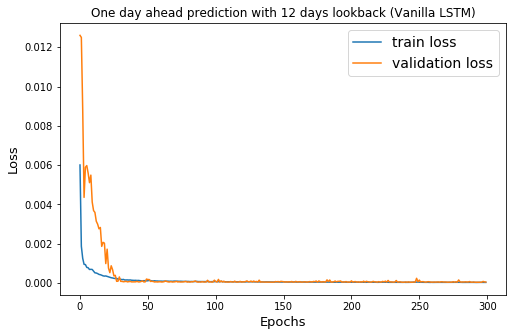

In [26]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8,5))
plt.plot(result.epoch, result.history['loss'], label="train loss")
plt.plot(result.epoch, result.history['val_loss'], label="validation loss")
plt.legend(fontsize=14)
plt.xlabel("Epochs", fontsize=13)
plt.ylabel("Loss", fontsize=13)
plt.title('One day ahead prediction with 12 days lookback (Vanilla LSTM)')
plt.show()

In [27]:
preds = model.predict(xtest)

## Predictive 

** The code below give the plot of the scaled data**


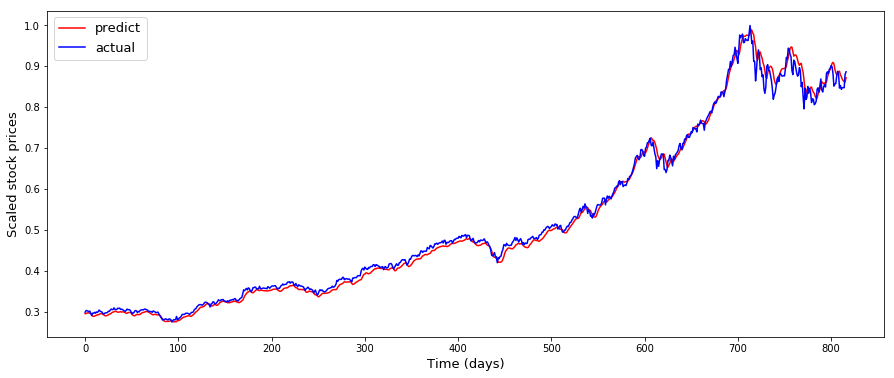

In [28]:
plt.figure(figsize=(15,6))
plt.plot(preds, color='r', linestyle="-",  label='predict')
plt.plot(ytest, color ='b', label='actual')
plt.xlabel("Time (days)", fontsize=13)
plt.ylabel("Scaled stock prices", fontsize=13)
plt.legend(fontsize=13)
plt.show()


## Transform the data

In [29]:
preds_ = model.predict(xdata_[train_size:])
_predicts=(scaler_1.inverse_transform(preds_))

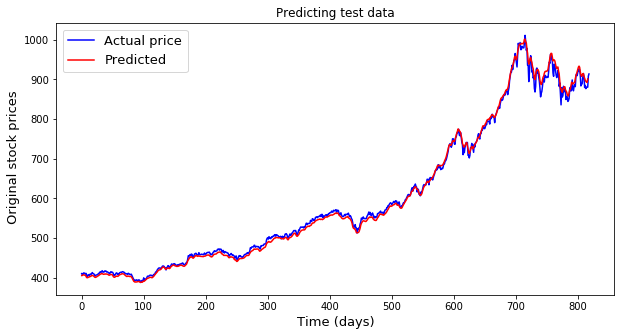

In [30]:
pyplot.figure(figsize=(10,5))
#plt.plot(p[1915:], color ='b')
#plt.plot(_predicts, color='r')
plt.plot(p[1915:], color ='b', linestyle="-",  label='Actual price')
plt.plot(_predicts, color='r',  linestyle="-",  label='Predicted')
plt.title("Predicting test data")
plt.xlabel("Time (days)", fontsize=13)
plt.ylabel(" Original stock prices", fontsize=13)
plt.legend(fontsize=13)
plt.show()

# Measures of Accuracy
** we used four statistical measures of accuracy to examine the performance of the LSTM model. We had the Mean Square Error (MSE), Root Mean Square Error (RMSE), Mean Absolute Error (MAE), and Mean Absolute Percentage Error (MAPE).**

## Mean Absolute Percentage Error MAPE

In [35]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100



In [36]:
Error_1 = mean_squared_error(p[1917:],_predicts)
RMSE = np.sqrt(Error_1)
Error_2 = mean_absolute_error(p[1917:],_predicts)
Error_3 = mean_absolute_percentage_error(p[1917:],_predicts)

print'The Mean Squared Error is ', Error_1
print

print'The Root Mean Squared Error is ', RMSE

print
print'The Mean Absolute Error is ', Error_2
print 
print'The Mean Absolute Percentage Error is ', Error_3

The Mean Squared Error is  144.05034821236225

The Root Mean Squared Error is  12.002097658841235

The Mean Absolute Error is  8.854770957545233

The Mean Absolute Percentage Error is  1.4459087805326667


** We implement another LSTM model, this time a stacked LSTM model. The stacked comes from the number of hidden LSTM layers**

** The same process is repeated as explained above and we compare the two LSTM models**

## Stacked LSTM

In [37]:
model2 = Sequential()
model2.add(LSTM(units = 64, return_sequences = True, input_shape=(lookback, 8)))
model2.add(LSTM(units = 64, return_sequences = True))
model2.add(Dropout(0.1))
model2.add(LSTM(units = 32))
model2.add(Activation("linear"))
model2.add(Dense(units = 1))
opt = optimizers.Adam(lr=0.00124)
model2.compile(loss="mse", optimizer=opt)

In [38]:
n_epochs = 300
valid_score = 0.20
start = time.time()
result_1=model2.fit(xtrain,ytrain,batch_size=128,nb_epoch=n_epochs,validation_split=valid_score, verbose =0)
print("> Compilation Time : ", time.time() - start)

/var/autofs/misc/home/mathews/.local/lib/python2.7/site-packages/ipykernel_launcher.py:4: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  after removing the cwd from sys.path.


('> Compilation Time : ', 414.6134169101715)


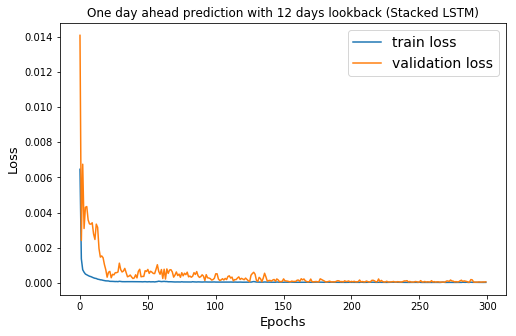

In [39]:
pyplot.figure(figsize=(8,5))
pyplot.plot(result_1.epoch, result_1.history['loss'], label="train loss")
pyplot.plot(result_1.epoch, result_1.history['val_loss'], label="validation loss")
#pyplot.plot(result.epoch, result.history['mean_absolute_error'], label="mae")
#pyplot.plot(result.epoch, result.history['val_mean_absolute_error'], label="val mae")
pyplot.legend(fontsize=14)
plt.xlabel("Epochs", fontsize=13)
plt.ylabel("Loss", fontsize=13)
plt.title('One day ahead prediction with 12 days lookback (Stacked LSTM)')
pyplot.show()

In [40]:
predicted_2 = model2.predict(xtest)

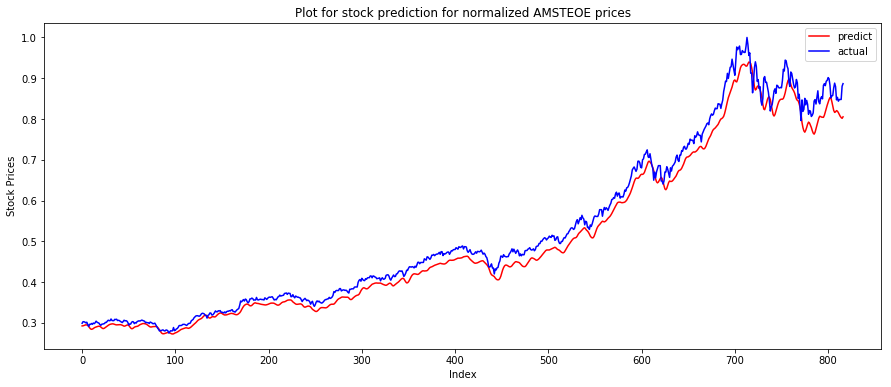

In [41]:
plt.figure(figsize=(15,6))
plt.plot(predicted_2, color='r', linestyle="-",  label='predict')
plt.plot(ytest, color ='b', label='actual')
plt.title("Plot for stock prediction for normalized AMSTEOE prices")
plt.xlabel("Index")
plt.ylabel("Stock Prices")
plt.legend()
plt.show()

## Data Transformation

In [42]:
preds_1 = model.predict(xdata_[train_size:])


In [43]:
_predicts_1=(scaler_1.inverse_transform(predicted_2))

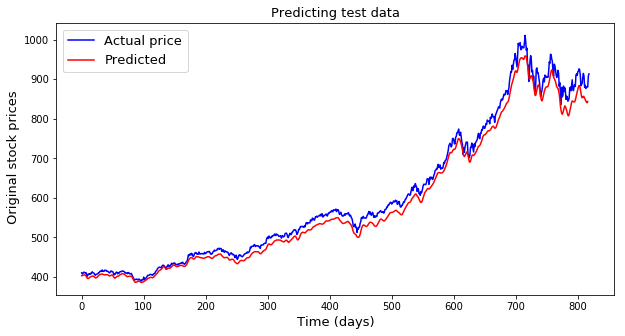

In [44]:
pyplot.figure(figsize=(10,5))
plt.plot(p[1915:], color ='b', linestyle="-",  label='Actual price')
plt.plot(_predicts_1, color='r',  linestyle="-",  label='Predicted')
plt.title("Predicting test data", fontsize = 13)
plt.xlabel("Time (days)", fontsize=13)
plt.ylabel(" Original stock prices", fontsize=13)
plt.legend(fontsize=13)
pyplot.show()

In [47]:
Error_1 = mean_squared_error(p[1917:],_predicts_1)
RMSE = np.sqrt(Error_1)
Error_2 = mean_absolute_error(p[1917:],_predicts_1)
Error_3 = mean_absolute_percentage_error(p[1917:],_predicts_1)

print'The Mean Squared Error is ', Error_1
print
print'The Root Mean Squared Error is ', RMSE
print
print'The Mean Absolute Error is ', Error_2

print 
print'The Mean Absolute Percentage Error is ', Error_3

The Mean Squared Error is  610.1644177095916

The Root Mean Squared Error is  24.70150638543309

The Mean Absolute Error is  20.624883105349223

The Mean Absolute Percentage Error is  3.258107257793832


## We can observe that increasing the LSTM hidden layer does not provide accurate predictions. Therefore, the stacked LSTM for 12 days previous time steps does not give an improvement on the performance of the predictive models. The vanilla LSTM model give a better forecast and it can easily be implemented.